In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gnwo2xxv because the default path (/home/gallil/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## single sentence evaluation

In [53]:
base_path = 'data/aclImdb/imdb'
path = base_path + '_a3c_results_indi_syn'
sent_num = '13'
sent_path = path + '/' + sent_num
sample_path = base_path + '_sample.csv'

In [54]:
df_sample = pd.read_csv(sample_path)

In [55]:
dfs = []
for j in range(6):
    if not os.path.isfile(f'{sent_path}/w{j}.txt'):
        print(f'no worker {j}')
    else:
        dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##"))

/storage/conda_envs/left/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [56]:
df = pd.concat(dfs)
df.columns = ['orig_sent', 'episode', 'score', 'sent']
df = df.sort_values('episode')
df = df.reset_index(drop=True)

graph of reward vs episode

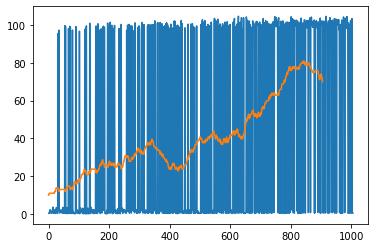

In [57]:
N=100
# df= df.iloc[:1000]
plt.plot(df.episode, df.score)
plt.plot(np.convolve(df.score, np.ones((N,))/N, mode='valid'))

find most simililar result

In [89]:
df.iloc[df.score.iloc[-4:-1].argmax()]

/storage/conda_envs/left/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


orig_sent    this may be one of the best movies i have ever...
episode                                                   1000
score                                                  102.285
sent         this might be one of the best movies i have ev...
Name: 999, dtype: object

In [90]:
df[df.score == df.score.max()].episode.max()

1002

In [91]:
print('original sentence: ', df_sample.content.iloc[int(sent_num)])
print('original label: ', df_sample.label.iloc[int(sent_num)])
print('original prediction: ', df_sample.preds.iloc[int(sent_num)])
df.iloc[df.score.idxmax()].episode, df.iloc[df.score.idxmax()].score, df.iloc[df.score.idxmax()].sent

original sentence:  this may be one of the best movies i have ever seen . it has anything but a trite plot , and leaves one wondering which way it will go next . it is an interesting portrayal of the struggles of youth , youth who are interested in more than immediate gratification , youth who show some concern about the desires and needs of others .
original label:  1
original prediction:  1


(23,
 102.284658908844,
 'this might be one of the best movies i have ever seen . it has anything but a trite plot , and leaves one wondering which way it will go next . it is an interesting portrayal of the struggles of youth , youth who are interested in more than immediate gratification , youth who show some concern about the desires and needs of others .')

#### calculate which examples are - easy, converged, successful and un-successful

In [ ]:
base_path = '../text-xai/data/toxic/toxic'
path = base_path + '_a3c_results_indi_syn'
wanted_texts = list(range(125))
sample_path = base_path + '_sample.csv'

In [9]:
def find_train_group(scores, N):
    mean_r = np.convolve(scores, np.ones((N,))/N, mode='valid')
    if (mean_r[:100].max()>90) and (mean_r[-1] > 90):                                 # Easy
        return 'easy'
    elif ((mean_r[0] <= 0.5 * mean_r[-1]) and mean_r[-1] > 40) or (mean_r[-1] > 80):  # converged
        return 'converged'
    elif scores.max() > 75:                                   # successful
        return 'success'
    else:                                                                             # unsuccesful
        return 'unsuccess'

In [ ]:
N = 100  # window size for mean
groups = {'easy': [], 'converged': [], 'success': [], 'unsuccess': []}

for sent_num in wanted_texts: 
    # load all results for specific text
    sent_path = path + '/' + str(sent_num)
    dfs = []
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##"))
    # adapt the format
    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    
    # aggregate the sum of the smoothed reward 
    cur_group = find_train_group(df.score, N)
    groups[cur_group].append(sent_num)

In [ ]:
groups

#### create the mean training reward plot of wanted texts

In [32]:
base_path = 'data/aclImdb/imdb'
path = base_path + '_relegate_results'
wanted_texts = [2, 12, 19, 24, 41, 67, 78, 83, 88, 92, 102, 4, 6, 13, 27, 28, 34, 35, 56, 60, 68, 77, 93, 96, 104, 119]

In [33]:
N = 100  # window size for mean
mean_train_reward = np.zeros(1000 - N)
for sent_num in wanted_texts: 
    # load all results for specific text
    sent_path = path + '/' + str(sent_num)
    dfs = []
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##", engine='python'))
    # adapt the format
    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    
    # aggregate the sum of the smoothed reward 
    mean_train_reward += np.convolve(df.score, np.ones((N,))/N, mode='valid')[:1000-N]
    
mean_train_reward /= len(wanted_texts)

no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5


In [34]:
mean_train_reward[-1]

90.66049137232568

## train test evaluation

In [2]:
base_path = 'data/aclImdb/imdb_relegate_results' # _imdb_tp_26_lunatc'

### train

In [3]:
path = base_path + '/train/'

In [4]:
epoch_dfs = []
for epoch in range(1):
    cur_path = path + str(epoch)
    dfs = []
    # iterate over different workers for same epoch
    for j in range(6):
        if not os.path.isfile(f'{cur_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{cur_path}/w{j}.txt', header=None, sep="##g##", engine='python'))
    
    # concatenate different workers
    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    
    # add specific epoch to list
    epoch_dfs.append(df)

# concatenate all epochs
df_train = pd.concat(epoch_dfs)
df_train = df_train.reset_index(drop=True)

no worker 4
no worker 5


In [5]:
len(df_train)

10002

### test

In [117]:
path = base_path + '/0/'

In [1033]:
epoch_dfs = []
for epoch in range(27):
    cur_path = path + str(epoch)
    dfs = []
    # iterate over different workers for same epoch
    for j in range(7):
        if not os.path.isfile(f'{cur_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{cur_path}/w{j}.txt', header=None, sep="##g##", engine='python'))
    
    # concatenate different workers
    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    df['epoch'] = epoch
    # add specific epoch to list
    epoch_dfs.append(df)

# concatenate all epochs
df_test = pd.concat(epoch_dfs)
df_test = df_test.reset_index(drop=True)

no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 1
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 1
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 1
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 1
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 1
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no worker 5
no worker 6
no worker 2
no worker 3
no worker 4
no w

/storage/conda_envs/bert_test/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/storage/conda_envs/bert_test/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/storage/conda_envs/bert_test/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are inte

### plots

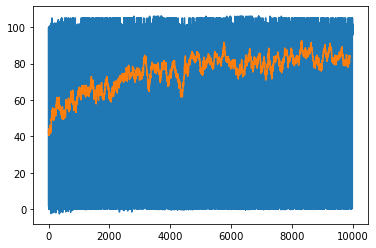

In [6]:
N = 100
plt.plot(df_train.score)
plt.plot(np.convolve(df_train.score, np.ones((N,))/N, mode='valid'))

In [7]:
(df_train.groupby('orig_sent').score.max()> 70).sum()

10

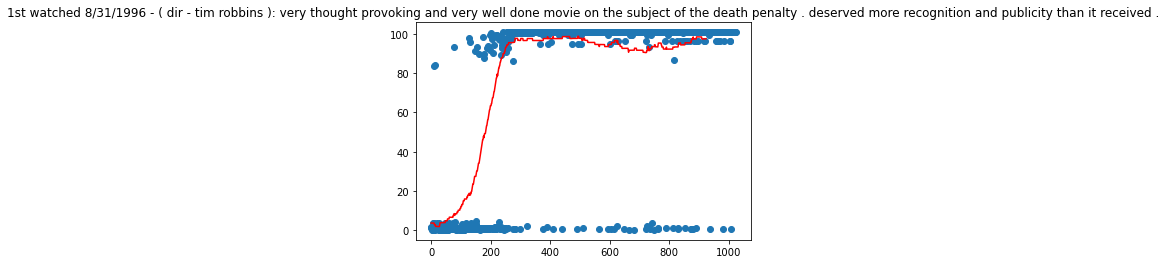

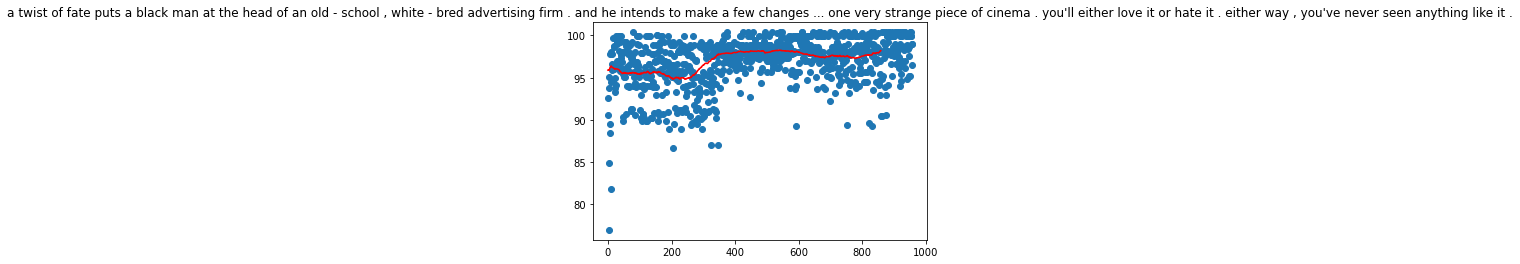

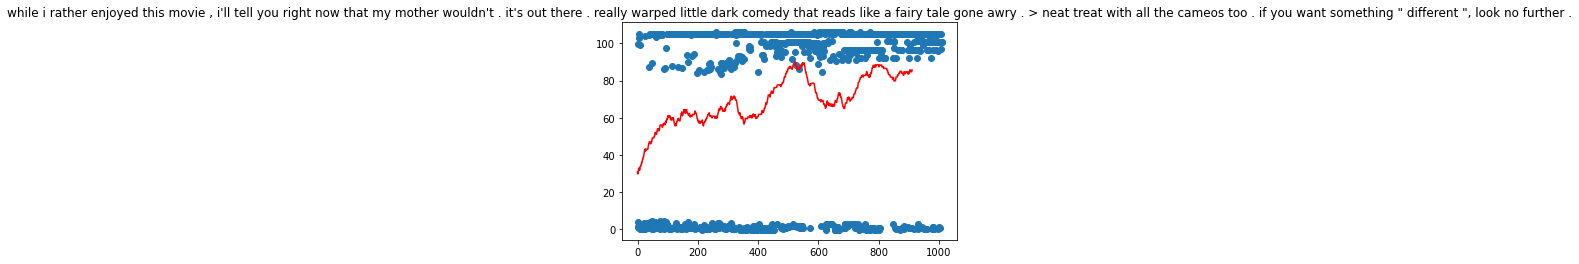

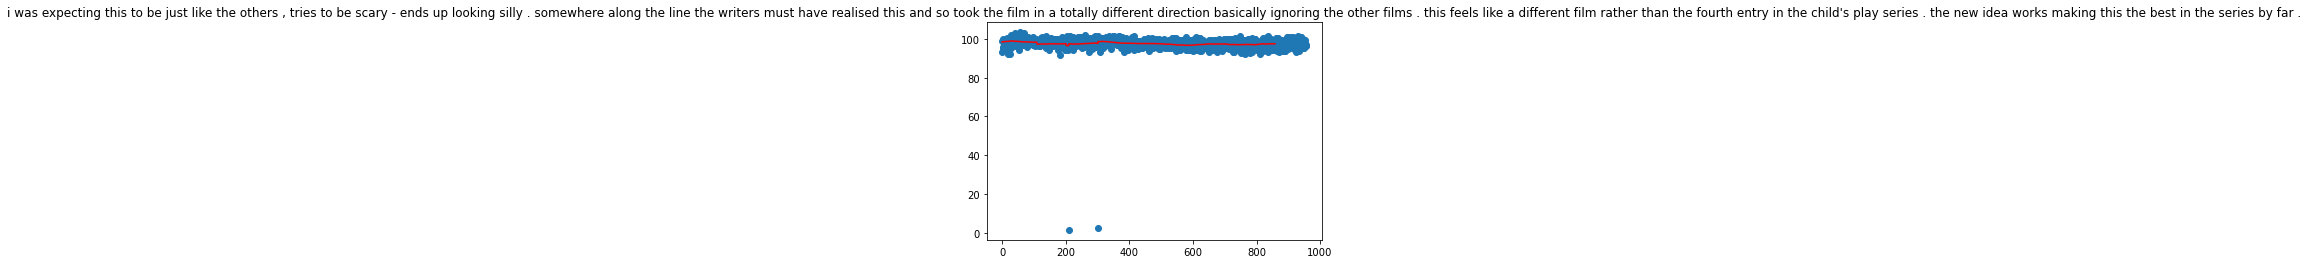

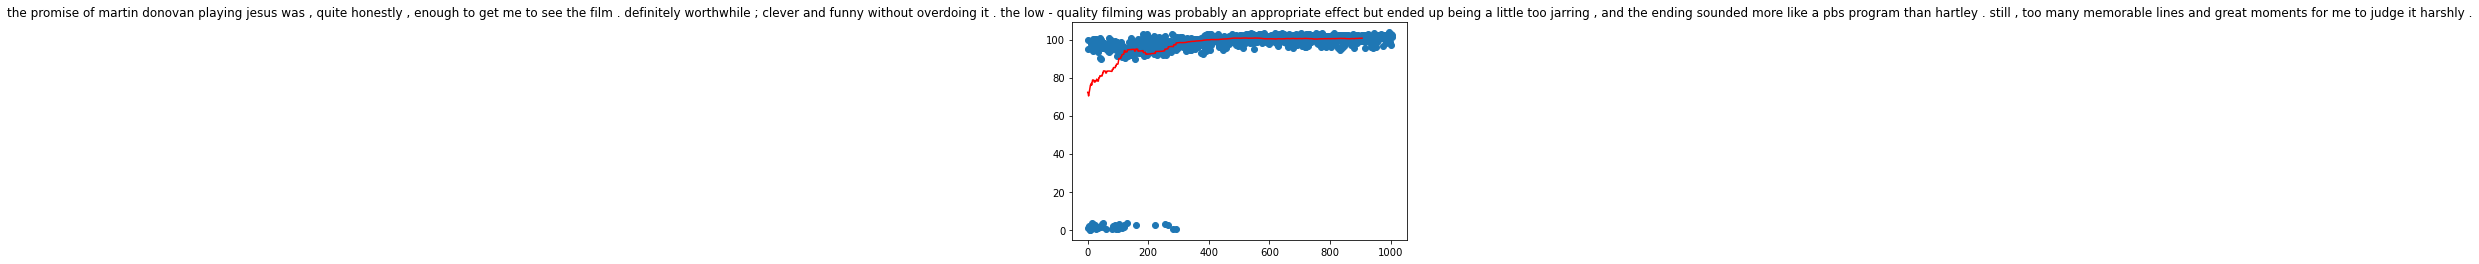

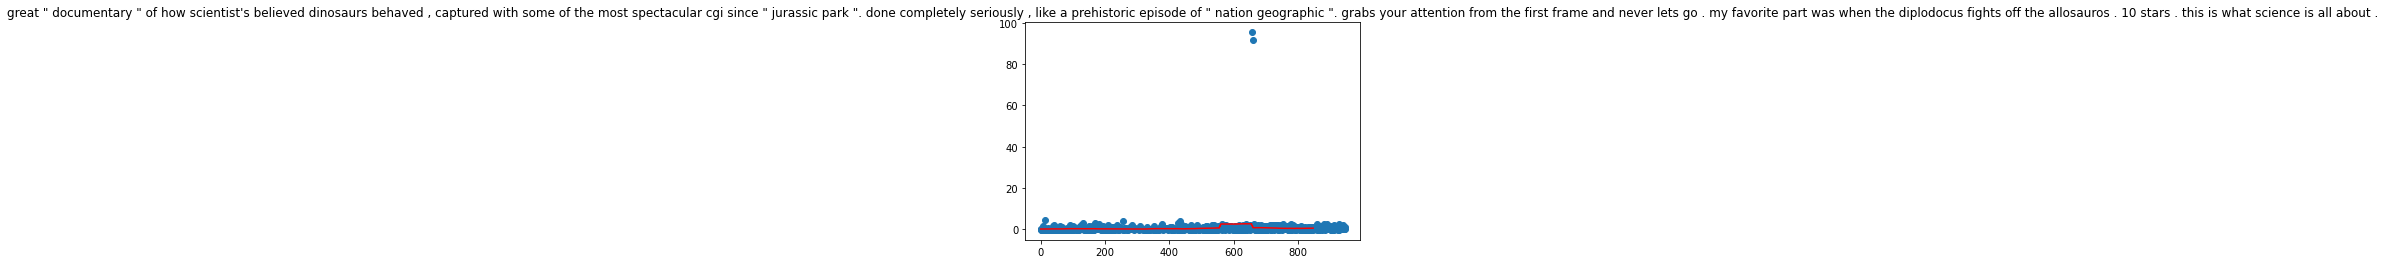

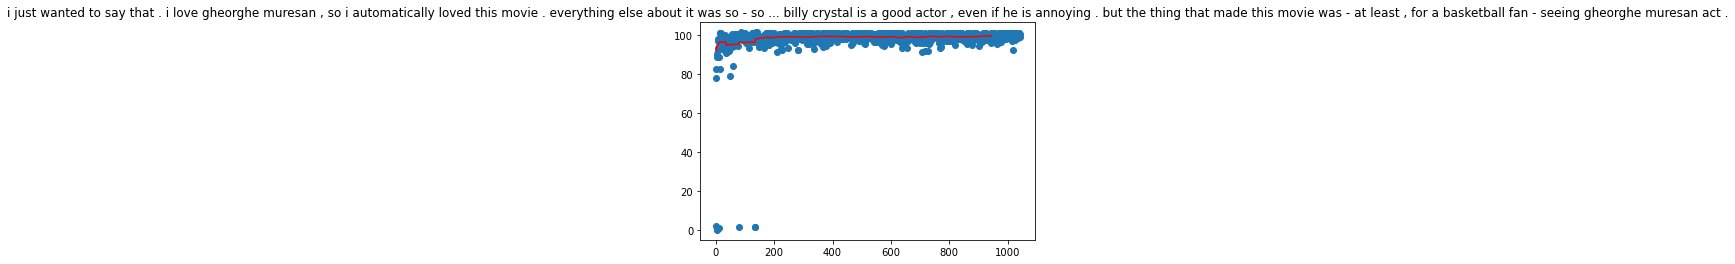

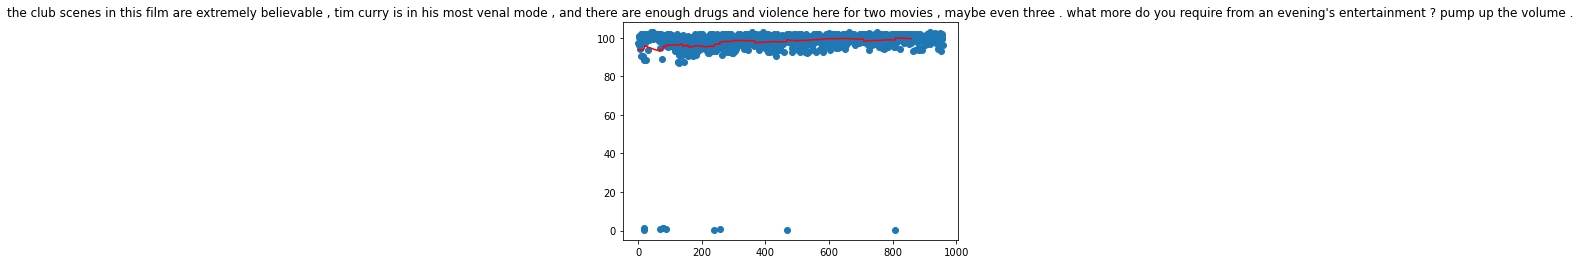

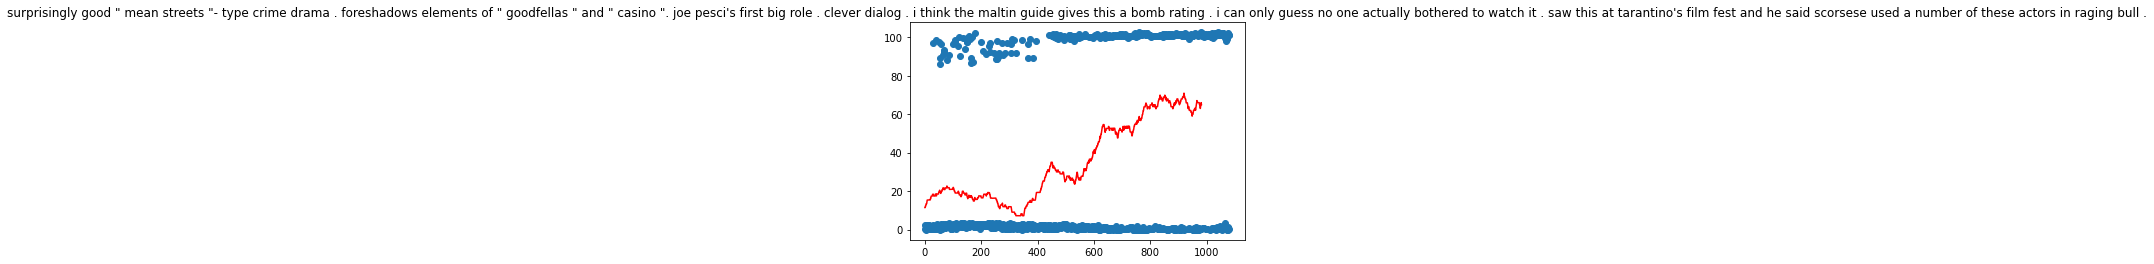

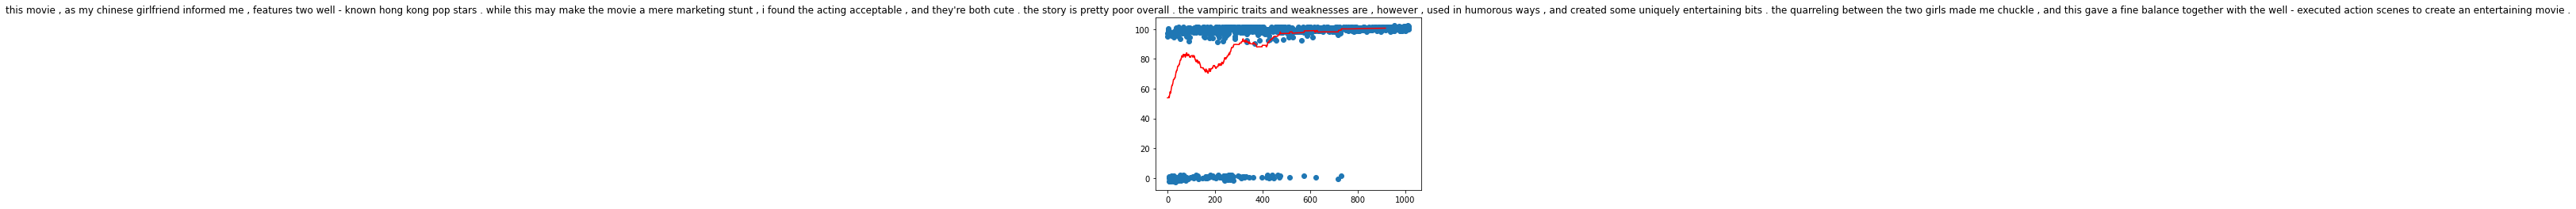

In [10]:
N = 100
result_groups = {'easy': 0, 'converged': 0, 'success': 0, 'unsuccess': 0}
mean_reward_lunatc = np.zeros(1000-N)
df = df_train

for orig in df.orig_sent.unique():
    plt.scatter(range(len(df[df.orig_sent == orig])), df[df.orig_sent == orig].score)
    smooth_r = np.convolve(df[df.orig_sent == orig].score, np.ones((N,))/N, mode='valid')
    plt.plot(smooth_r, 'r')
    result_groups[find_train_group(df[df.orig_sent == orig].score, N)] += 1  # update which group it is
    mean_reward_lunatc[-len(smooth_r[:1000-N]):] += smooth_r[:1000-N]  # aggregate all smoothed rewards for mean
    plt.title(orig)
    plt.show()

mean_reward_lunatc /= df.orig_sent.nunique()

In [24]:
df_train.groupby('orig_sent').apply(len).values.min()

923

#### plot universal vs. individual smoothed reward plot

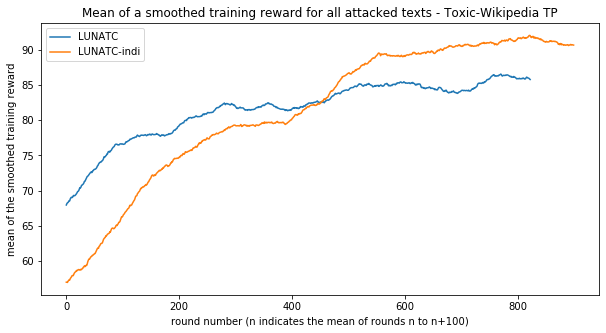

In [35]:
plt.figure(figsize=(10,5))
plt.plot(mean_reward_lunatc[77:], label="LUNATC")  # We clip the beginning as it is zero filled by defualt for text which have less than 1000 rounds
plt.plot(mean_train_reward, label="LUNATC-indi")
plt.xlabel('round number (n indicates the mean of rounds n to n+100)')
plt.ylabel('mean of the smoothed training reward')
plt.legend()
plt.title('Mean of a smoothed training reward for all attacked texts - Toxic-Wikipedia TP')
plt.savefig('Toxic-TP', dpi=300)
plt.show()

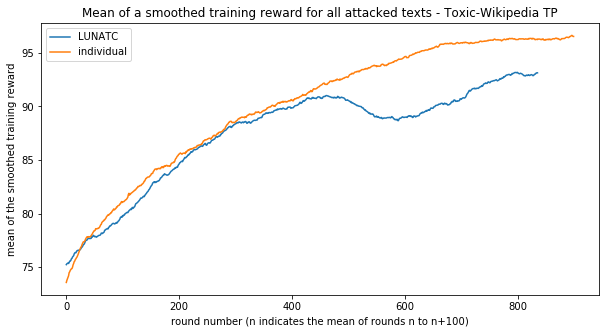

In [272]:
plt.figure(figsize=(10,5))
plt.plot(mean_reward_lunatc[64:], label="LUNATC")  # We clip the beginning as it is zero filled by defualt for text which have less than 1000 rounds
plt.plot(mean_train_reward, label='individual')
plt.xlabel('round number (n indicates the mean of rounds n to n+100)')
plt.ylabel('mean of the smoothed training reward')
plt.legend()
plt.title('Mean of a smoothed training reward for all attacked texts - Toxic-Wikipedia TP')
plt.savefig('Toxic-TP', dpi=300)
plt.show()

ablation study

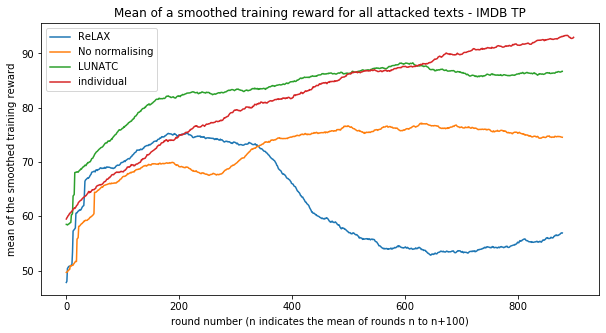

In [252]:
plt.figure(figsize=(10,5))
plt.plot(mean_reward_lunatc[20:], label="ReLAX")  # We clip the beginning as it is zero filled by defualt for text which have less than 1000 rounds
plt.plot(mean_reward_no_norm[20:], label="No normalising")  # We clip the beginning as it is zero filled by defualt for text which have less than 1000 rounds
plt.plot(mean_reward_luni[20:], label="LUNATC")
plt.plot(mean_train_reward, label='individual')
plt.xlabel('round number (n indicates the mean of rounds n to n+100)')
plt.ylabel('mean of the smoothed training reward')
plt.legend()
plt.title('Mean of a smoothed training reward for all attacked texts - IMDB TP')
plt.savefig('Ablation study', dpi=300)
plt.show()

## multi sentence training evaluation

In [ ]:
base_path = 'data/aclImdb/imdb_a3c_results_20sents'
path = base_path + '/train/0'

In [ ]:
dfs = []
for j in range(6):
    if not os.path.isfile(f'{path}/w{j}.txt'):
        print(f'no worker {j}')
    else:
        dfs.append(pd.read_csv(f'{path}/w{j}.txt', header=None, sep="##g##"))

In [ ]:
df = pd.concat(dfs)
df.columns = ['orig_sent', 'episode', 'score', 'sent']
df = df.sort_values('episode')
df = df.reset_index(drop=True)

In [ ]:
len(df)

In [ ]:
df.orig_sent.value_counts()

### try to evaluate if learning 

#### see general graph

In [ ]:
N = 1000
plt.scatter(df.episode, df.score)
plt.plot(np.convolve(df.score, np.ones((N,))/N, mode='valid'), 'r')
plt.show()

#### see improvement of each sentence seperately 

In [ ]:
N = 50
for orig in df.orig_sent.unique():
    plt.scatter(df[df.orig_sent == orig].episode, df[df.orig_sent == orig].score)
    plt.plot(df[df.orig_sent == orig].episode[:-N+1], np.convolve(df[df.orig_sent == orig].score, np.ones((N,))/N, mode='valid'), 'r')
    plt.title(orig)
    plt.show()

#### generate paper graph

In [ ]:
grouped = df.groupby('orig_sent').apply(lambda g: g.max().score > 70)
df['keep'] = df.orig_sent.apply(lambda x: grouped.loc[x])

In [ ]:
plt.figure(figsize=(8,2.5))
N = 50
lens = []
for orig in df[df.keep].orig_sent.unique()[[0,2,3,4, 6]]:
    plt.plot(df[df.orig_sent == orig].episode[:-N+1], np.convolve(df[df.orig_sent == orig].score, np.ones((N,))/N, mode='valid'), '--', alpha=0.5)
    lens.append(df[df.orig_sent == orig].episode[:-N+1].max())

N=300
plt.plot(df[df.keep & (df.episode < np.max(lens))].episode[:-N+1], np.convolve(df[df.keep & (df.episode < np.max(lens))].score, np.ones((N,))/N, mode='valid'), 'r', label="all texts mean")
plt.xlabel('Number of rounds')
plt.ylabel('Moving avrage of reward')
# plt.title('Reward moving average for each sentence')
plt.legend(loc="lower right")

# plt.show()
plt.savefig('20_text_convergence-small.png', dpi=300, bbox_inches='tight')

## multiple sentence evaluation

### produce csvs

In [396]:
base_path = 'data/spam/spam'
data_path = base_path + '_random_results' # '_random_results'
sample_path = base_path + '_sample.csv'
out_path = data_path + '/results.csv'

In [397]:
num_episodes = 1000
num_examples = 500
df_sample = pd.read_csv(sample_path)
df_sample = df_sample.head(num_examples)

max_scores = []
epoch_found = []
best_sent = []


for sent_num in range(num_examples):

    sent_path = data_path + '/' + str(sent_num)
    
    dfs = []
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##", engine='python'))

    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    df = df.head(num_episodes)
    
    epoch_found.append(df.iloc[df.score.idxmax()].episode)
    max_scores.append(df.iloc[df.score.idxmax()].score)
    best_sent.append(df.iloc[df.score.idxmax()].sent)
    
df_sample["max_scores"] = max_scores
df_sample["epoch_found"] = epoch_found
df_sample["best_sent"] = best_sent
df_sample["orig_sent_len"] = df_sample.content.apply(lambda x: len(x.split()))
df_sample["words_changed"] = df_sample.apply(lambda x: (np.array(x.content.split())!=np.array(x.best_sent.split())).sum(), axis=1)

df_sample.to_csv(out_path, index=False)

no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no worker 5
no worker 4
no w

### produce first success epoch csv

In [701]:
base_path = 'data/toxic/toxic'
data_path = base_path + '_random_results' # '_random_results'
sample_path = base_path + '_sample.csv'
out_path = data_path + '/first_success.csv'

In [702]:
num_episodes = 5000
num_examples = 500
df_sample = pd.read_csv(sample_path)
df_sample = df_sample.head(num_examples)

max_scores = []
epoch_found = []
best_sent = []


for sent_num in range(num_examples):

    sent_path = data_path + '/' + str(sent_num)
    
    dfs = []
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##", engine='python'))

    df = pd.concat(dfs)
    df.columns = ['episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    df = df.head(num_episodes)
    
    epoch_found.append(df.iloc[(df.score > 70).idxmax()].episode)
    max_scores.append(df.iloc[(df.score > 70).idxmax()].score)
    best_sent.append(df.iloc[(df.score > 70).idxmax()].sent)
    
df_sample["max_scores"] = max_scores
df_sample["epoch_found"] = epoch_found
df_sample["best_sent"] = best_sent
df_sample["orig_sent_len"] = df_sample.content.apply(lambda x: len(x.split()))
df_sample["words_changed"] = df_sample.apply(lambda x: (np.array(x.content.split())!=np.array(x.best_sent.split())).sum(), axis=1)

df_sample.to_csv(out_path, index=False)

no worker 5
no worker 5
no worker 5
no worker 5
no worker 5
no worker 4
no worker 5
no worker 5
no worker 5
no worker 4
no worker 5


### produce last success epoch csv

In [1]:
base_path = 'data/aclImdb/imdb'
data_path = base_path + '_a3c_results_indi_syn' # '_random_results'
sample_path = base_path + '_sample.csv'
out_path = data_path + '/last_success.csv'

In [ ]:
num_episodes = 1000
num_examples = 500
df_sample = pd.read_csv(sample_path)
df_sample = df_sample.head(num_examples)

max_scores = []
epoch_found = []
best_sent = []


for sent_num in range(num_examples):

    sent_path = data_path + '/' + str(sent_num)
    
    dfs = []
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##", engine='python'))

    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    df = df.sort_values('episode')
    df = df.reset_index(drop=True)
    df = df.head(num_episodes)
    
    if (df.score > 70).any():
        final_ind = df[(df.score > 70)].episode.idxmax()
        epoch_found.append(df.iloc[final_ind].episode)
        max_scores.append(df.iloc[final_ind].score)
        best_sent.append(df.iloc[final_ind].sent)
    else:
        final_episode = 0
        epoch_found.append(final_episode)
        max_scores.append(-1)
        best_sent.append("")
    
df_sample["max_scores"] = max_scores
df_sample["epoch_found"] = epoch_found
df_sample["best_sent"] = best_sent
df_sample["orig_sent_len"] = df_sample.content.apply(lambda x: len(x.split()))
# df_sample["words_changed"] = df_sample.apply(lambda x: (np.array(x.content.split())!=np.array(x.best_sent.split())).sum(), axis=1)

df_sample.to_csv(out_path, index=False)

### calculate oracle usage

In [ ]:
base_path = '../text-xai/data/clickbait/clickbait'
data_path = base_path + '_a3c_results' # '_random_results'

In [ ]:
num_episodes = 5000
num_examples = 500
bad_oracle_usage = []
good_oracle_usage = []

for sent_num in range(num_examples):

    sent_path = data_path + '/' + str(sent_num)
   
    dfs = []
    states = set()
    for j in range(6):
        if not os.path.isfile(f'{sent_path}/w{j}.txt'):
            print(f'no worker {j}')
        else:
            dfs.append(pd.read_csv(f'{sent_path}/w{j}.txt', header=None, sep="##g##", engine='python'))
       
        if not os.path.isfile(f'{sent_path}/w{j}_states.txt'):
            print(f'no worker {j}')
        else:
            with open(f'{sent_path}/w{j}_states.txt', 'rb') as f:
                content = f.readlines()
            states = (states | (set([x.rstrip() for x in content])))
    df = pd.concat(dfs)
    df.columns = ['orig_sent', 'episode', 'score', 'sent']
    if len(df) >= 1000:
        bad_oracle_usage.append(len(states))
    else:
        good_oracle_usage.append(len(states))

In [ ]:
len(good_oracle_usage), len(bad_oracle_usage)

In [ ]:
np.median(good_oracle_usage), np.median(bad_oracle_usage)

### analyse CSVs

#### similarity calulation utility

In [ ]:
# calculate success
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.Module("resources/tf_hub_modules/USE")

# sentence similarity - placed globally to avoid leakage
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)

def get_similarity(messages, sess):
    """ calculates the similarity between the first message and the others using Universal Sentence encoder"""
    message_embeddings = sess.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: messages})
    corr = np.inner(message_embeddings[0], message_embeddings[1:])
    return corr

In [ ]:
sess = tf.Session()
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

#### load dataset CSVs

In [ ]:
csv_paths = ['aclImdb/imdb', 'spam/spam', 'clickbait/clickbait', 'toxic/toxic']
csv_paths = ['clickbait/clickbait']
# load dataframes
df_list = [pd.read_csv('../text-xai4/data/' + dataset + '_a3c_results_indi_synmis/results.csv') for dataset in csv_paths]
random_df_list = [pd.read_csv('../text-xai4/data/' + dataset + '_random_results_indi_synmis/results.csv') for dataset in csv_paths]

# calculate similarity
for df in df_list:
    df.best_sent = df.best_sent.fillna('') # fill nan - for when agent deleted all words in string
    df["similarity"] = df.apply(lambda x: get_similarity([x.content, x.best_sent], sess)[0], axis=1)
    
for df in random_df_list:
    df.best_sent = df.best_sent.fillna('')  # fill nan - for when agent deleted all words in string
    df["similarity"] = df.apply(lambda x: get_similarity([x.content, x.best_sent], sess)[0], axis=1)

# calculate masks
mask_list = [(df.max_scores>70) & (df.similarity > 0.7) for df in df_list]
random_mask_list = [(df.max_scores>70) & (df.similarity > 0.7) for df in random_df_list] 

mask_list = [(df.max_scores>70) for df in df_list]
random_mask_list = [(df.max_scores>70) for df in random_df_list] 

#### Textfooler

In [ ]:
df_mits = [pd.read_csv('data/' + dataset + '_mit.csv').head(500) for dataset in csv_paths]
# calculate words changed
for j in range(len(csv_paths)):
    df_mits[j]["words_changed"] = df_mits[j].apply(lambda x: (np.array(x.content.split())!=np.array(x.best_sent.split())).sum(), axis=1)
#     df_mits[j]["max_actions"] = df_mits[j].content.apply(number_of_actions)
#     df_mits[j]["oracle_usage"] = df_mits[j]["max_actions"] + df_mits[j]["words_changed"]
    
masks_mit = [df.max_score > .7 for df in df_mits]

#### PWWS

In [ ]:
df_pwws = [pd.read_csv('data/' + dataset + '_pwws.csv').head(500) for dataset in csv_paths]
# calculate words changed
# for j in range(len(csv_paths)):
#     df_pwws[j]["words_changed"] = df_pwws[j].apply(lambda x: (np.array(x.content.split())!=np.array(x.best_sent.split())).sum(), axis=1)
#     df_pwws[j]["max_actions"] = df_pwws[j].content.apply(number_of_actions)
#     df_pwws[j]["oracle_usage"] = df_pwws[j]["max_actions"] + df_pwws[j]["words_changed"]
    
masks_pwws = [df.max_score > .7 for df in df_pwws]

#### calculate mean USE similarities for each approach on succesful

In [ ]:
for i in range(len(csv_paths)):
    mask = mask_list[i] & random_mask_list[i] & masks_mit[i] & masks_pwws[i]
    print(csv_paths[i], df_list[i][mask].similarity.mean(), random_df_list[i][mask].similarity.mean(), df_mits[i][mask].max_score.mean(), df_pwws[i][mask].max_score.mean())

#### plot success rate as function of available words

In [448]:
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
word_vectors = KeyedVectors.load_word2vec_format("resources/word_vectors/counter-fitted-vectors_formatted.txt", binary=False)

/storage/conda_envs/bert_test/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [742]:
STOPWORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [449]:
# first calculate the number of available actions
def number_of_actions(text):
    words = text.split()
    content_words = [i for i,w in enumerate(words) if w not in STOPWORDS and w in word_vectors]
    return len(content_words)

In [1077]:
for j in range(len(csv_paths)):
    df_list[j]["num_actions_max"] = df_list[j].content.apply(number_of_actions)
    random_df_list[j]["num_actions_max"] = random_df_list[j].content.apply(number_of_actions)

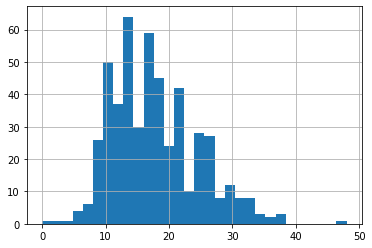

In [1066]:
df_list[0].num_actions_max.hist(bins=30)

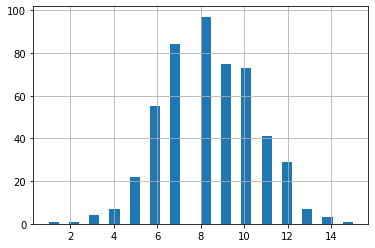

In [669]:
df_list[2].num_actions_max.hist(bins=30)

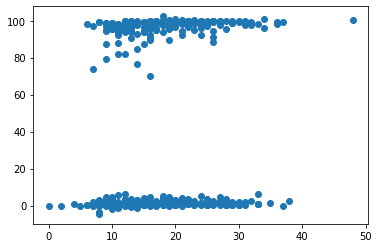

In [652]:
plt.scatter(df_list[0].num_actions_max, df_list[0].max_scores)

In [775]:
scores = []
rand_scores = []
for j in range(4):
    df_list[j]['success'] = mask_list[j]
    scores.append(df_list[j].groupby(df_list[j].num_actions_max//10).apply(np.mean))
    
    random_df_list[j]['success'] = random_mask_list[j]
    rand_scores.append(random_df_list[j].groupby(df_list[j].num_actions_max//10).apply(np.mean))

Text(0.5, 1.0, 'aclImdb/imdb')

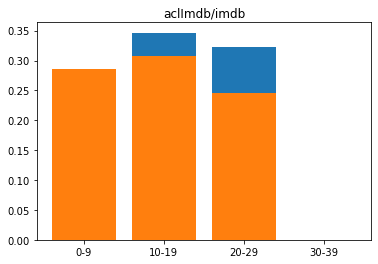

In [732]:
plt.bar(['0-9', '10-19', '20-29', '30-39'], scores[0].success)
plt.title(csv_paths[0])

Text(0.5, 1.0, 'aclImdb/imdb')

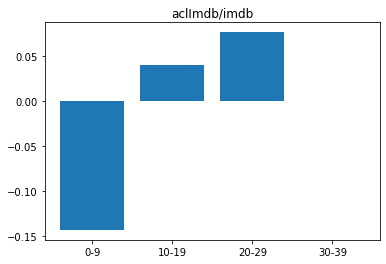

In [733]:
plt.bar(['0-9', '10-19', '20-29', '30-39'], scores[0].success - rand_scores[0].success)
plt.title(csv_paths[0])

Text(0.5, 1.0, 'spam/spam')

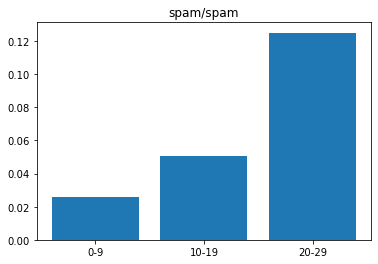

In [718]:
plt.bar(['0-9', '10-19', '20-29'], scores[1].success)
plt.title(csv_paths[1])

Text(0.5, 1.0, 'spam/spam')

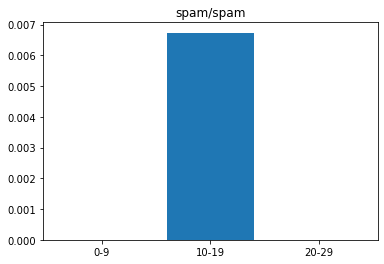

In [734]:
plt.bar(['0-9', '10-19', '20-29'], scores[1].success - rand_scores[1].success)
plt.title(csv_paths[1])

Text(0.5, 1.0, 'clickbait/clickbait')

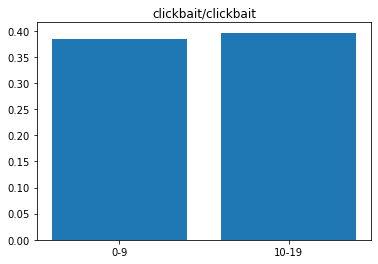

In [719]:
plt.bar(['0-9', '10-19'], scores[2].success)
plt.title(csv_paths[2])

Text(0.5, 1.0, 'clickbait/clickbait')

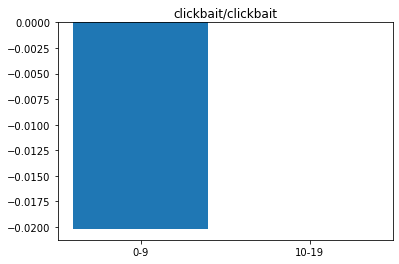

In [735]:
plt.bar(['0-9', '10-19'], scores[2].success - rand_scores[2].success)
plt.title(csv_paths[2])

Text(0.5, 1.0, 'toxic/toxic')

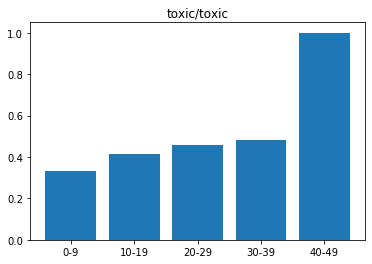

In [720]:
plt.bar(['0-9', '10-19', '20-29', '30-39', '40-49'], scores[3].success)
plt.title(csv_paths[3])

Text(0.5, 1.0, 'toxic/toxic')

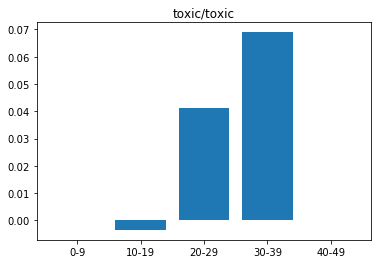

In [736]:
plt.bar(['0-9', '10-19', '20-29', '30-39', '40-49'], scores[3].success - rand_scores[3].success)
plt.title(csv_paths[3])

In [ ]:
list_no_spam = [df_list[0], df_list[2], df_list[3]]
tmp = pd.concat(df_list)
tmp2 = pd.concat(list_no_spam)

In [ ]:
res = tmp.groupby(tmp.num_actions_max//5).apply(np.mean)
res2 = tmp2.groupby(tmp2.num_actions_max//10).apply(np.mean)

In [ ]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(211)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.bar(['0-9', '10-19', '20-29', '30-39'], scores[1].success)
ax2.bar(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59'], res2.success)

ax1.set_title('Spam dataset')
ax2.set_title('All other datasets except spam')

ax1.set_xlabel('Number of possible actions at initial state')
ax1.set_ylabel('Attack success rate')
ax2.set_xlabel('Number of possible actions at initial state')
ax2.set_ylabel('Attack success rate')

plt.savefig('success_rate.png', dpi=300)

#### success rate as function of rounds

In [ ]:
csv_paths = ['toxic/toxic', 'clickbait/clickbait']
df_list = [pd.read_csv('data/' + dataset + '_a3c_results_indi_synmis/first_success.csv') for dataset in csv_paths]
mask_list = [df.max_scores>70 for df in df_list]
random_df_list = [pd.read_csv('data/' + dataset + '_random_results_indi_synmis/first_success.csv') for dataset in csv_paths]
random_mask_list = [df.max_scores>70 for df in random_df_list] 

In [ ]:
fig = plt.figure(figsize=(11,3.5))

ax = [fig.add_subplot(121), fig.add_subplot(122)]
display_names = ['Toxic-Wikipedia', 'Clickbait']

for j in range(len(csv_paths)):
    # a3c
    df_list[0]["success"] = mask_list[0]
    sorted_df = df_list[0].sort_values("epoch_found")
#     print("num of rounds before surpassing MIT: ", sorted_df.loc[((sorted_df.success.cumsum()/len(sorted_df)) > 0.216).idxmax()].epoch_found)
    ax[j].plot(sorted_df.epoch_found, sorted_df.success.cumsum()/len(sorted_df), label='ReLegGATe (syn-mis)')
    
    # TEXTFOOLER
    ax[j].plot(masks_mit[j].mean() * np.ones(1000), label='Textfooler')
    # PWWS
    ax[j].plot(masks_pwws[j].mean() * np.ones(1000), label='PWWS')
    
    # random
    random_df_list[0]["success"] = random_mask_list[0]
    sorted_df = random_df_list[0].sort_values("epoch_found")
#     print("num of rounds before surpassing MIT: ", sorted_df.loc[((sorted_df.success.cumsum()/len(sorted_df)) > 0.216).idxmax()].epoch_found)
    ax[j].plot(sorted_df.epoch_found, sorted_df.success.cumsum()/len(sorted_df), label='Basic search (syn-mis)')

    ax[j].set_xlabel('Number of rounds')
    ax[j].set_ylabel('Attack success rate')
    ax[j].set_title(f'{display_names[j]}')
    
    
ax[0].legend()    
# plt.show()
plt.savefig('success_rate_vs_rounds.png', dpi=300, bbox_inches='tight')

### success rate at the end to evaluate learning

In [ ]:
csv_paths = ['toxic/toxic', 'aclImdb/imdb']
df_list = [pd.read_csv('data/' + dataset + '_a3c_results_indi_syn/last_success.csv') for dataset in csv_paths]
mask_list = [df.max_scores>70 for df in df_list]
random_df_list = [pd.read_csv('data/' + dataset + '_random_results_indi_syn/last_success.csv') for dataset in csv_paths]
random_mask_list = [df.max_scores>70 for df in random_df_list] 

In [ ]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
# ax = fig.add_subplot(211)    # The big subplot
ax1 = fig.add_subplot(211, xscale='log')
ax2 = fig.add_subplot(212, xscale='log')

# Turn off axis lines and ticks of the big subplot
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# first plot one dataset
# a3c
df_list[0]["success"] = mask_list[0]
df_list[0].epoch_found = df_list[0].epoch_found.clip(upper=1000)
sorted_df = df_list[0].sort_values("epoch_found", ascending=False)
ax1.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(df_list[0]), 'b', label='ReLeGATe')

# random
random_df_list[0]["success"] = random_mask_list[0]
random_df_list[0].epoch_found = random_df_list[0].epoch_found.clip(upper=1000)
sorted_df = random_df_list[0].sort_values("epoch_found", ascending=False)
ax1.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(random_df_list[0]), 'r--', label='basic search')

# MIT
ax1.plot(1000*[masks_mit[0].mean()], ':', label='Textfooler baseline')

# plot second dataset    
# a3c
df_list[1]["success"] = mask_list[1]
df_list[1].epoch_found = df_list[1].epoch_found.clip(upper=1000)
sorted_df = df_list[1].sort_values("epoch_found", ascending=False)
ax2.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(df_list[1]), 'b', label='ReLeGATe')

# random
random_df_list[1]["success"] = random_mask_list[1]
random_df_list[1].epoch_found = random_df_list[1].epoch_found.clip(upper=1000)
sorted_df = random_df_list[1].sort_values("epoch_found", ascending=False)
ax2.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(random_df_list[1]), 'r--', label='basic search')

# MIT
ax2.plot(1000*[masks_mit[1].mean()], ':', label='Textfooler baseline')

ax1.legend(loc="lower right")

# Set common labels
# ax.set_xlabel('Number of rounds from the end of training evaluated on')
# ax.set_ylabel('Attack success rate')

ax1.set_title('Toxic wikipedia')
ax2.set_title('IMDB')
ax1.set_xlabel('Number of rounds from the end of training evaluated on')
ax1.set_ylabel('Attack success rate')
ax2.set_xlabel('Number of rounds from the end of training evaluated on')
ax2.set_ylabel('Attack success rate')

plt.savefig('final_rounds_sr.png', dpi=300, bbox_inches='tight')

### success rate as function of similarity threshold

In [ ]:
for i in range(len(csv_paths)):
    df_list[i].similarity *= (df_list[i].max_scores>10)
    random_df_list[i].similarity *= (random_df_list[i].max_scores>10)

In [ ]:
relegate_scores = [[] for i in range(len(csv_paths))]
textfooler_scores = [[] for i in range(len(csv_paths))]
pwws_scores = [[] for i in range(len(csv_paths))]
search_scores = [[] for i in range(len(csv_paths))]
sim_thresh = np.linspace(0., 1., 100)

for thresh in sim_thresh:
    for i in range(len(csv_paths)):
        relegate_scores[i].append((df_list[i].similarity > thresh).sum()/500)
        textfooler_scores[i].append((df_mits[i].max_score > thresh).sum()/500)
        pwws_scores[i].append((df_pwws[i].max_score > thresh).sum()/500)
        search_scores[i].append((random_df_list[i].similarity > thresh).sum()/500)

In [ ]:
fig = plt.figure(figsize=(11,3.5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(sim_thresh, relegate_scores[0], label='ReLeGATe (syn-mis)')
ax1.plot(sim_thresh, textfooler_scores[0], label='Textfooler')
ax1.plot(sim_thresh, pwws_scores[0], label='PWWS')
ax1.plot(sim_thresh, search_scores[0], label='Basic search (syn-mis)')
ax1.legend()
ax1.set_xlabel('USE similarity threshold')
ax1.set_ylabel('attack success rate')
ax1.set_title('Toxic-Wikipedia')

ax2.plot(sim_thresh, relegate_scores[1], label='ReLeGATe (syn-mis)')
ax2.plot(sim_thresh, textfooler_scores[1], label='Textfooler')
ax2.plot(sim_thresh, pwws_scores[1], label='PWWS')
ax2.plot(sim_thresh, search_scores[1], label='Basic search (syn-mis)')
ax2.set_xlabel('USE similarity threshold')
ax2.set_ylabel('attack success rate')
ax2.set_title('Clickbait')

plt.savefig('sr_for_sim_threshs.png', dpi=300, bbox_inches='tight')

### compare the 3 methods

#### success rate as function of rounds

In [1012]:
csv_paths = ['aclImdb/imdb', 'rt-polaritydata/polarity', 'sentiment labelled sentences/short_sentences', 'clickbait/clickbait']
df_list = [pd.read_csv('data/' + dataset + '_a3c_results_best/first_success.csv') for dataset in csv_paths]
mask_list = [df.max_scores>70 for df in df_list]
random_df_list = [pd.read_csv('data/' + dataset + '_random_results_best/first_success.csv') for dataset in csv_paths]
random_mask_list = [df.max_scores>70 for df in random_df_list] 

num of rounds before surpassing MIT:  2
num of rounds before surpassing MIT:  2


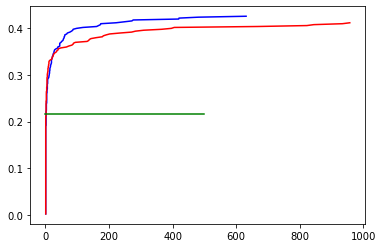

In [712]:
for j in range(len(csv_paths)):
    # a3c
    df_list[0]["success"] = mask_list[0]
    sorted_df = df_list[0].sort_values("epoch_found")
    print("num of rounds before surpassing MIT: ", sorted_df.loc[((sorted_df.success.cumsum()/len(sorted_df)) > 0.216).idxmax()].epoch_found)
    plt.plot(sorted_df.epoch_found, sorted_df.success.cumsum()/len(sorted_df), 'b')

    # random
    random_df_list[0]["success"] = random_mask_list[0]
    sorted_df = random_df_list[0].sort_values("epoch_found")
    print("num of rounds before surpassing MIT: ", sorted_df.loc[((sorted_df.success.cumsum()/len(sorted_df)) > 0.216).idxmax()].epoch_found)
    plt.plot(sorted_df.epoch_found, sorted_df.success.cumsum()/len(sorted_df), 'r')

    # MIT
    plt.plot(0.216 * np.ones(500), 'g-')
    plt.show()

### success rate at the end to evaluate learning

In [ ]:
csv_paths = ['toxic/toxic', 'aclImdb/imdb']
df_list = [pd.read_csv('data/' + dataset + '_a3c_results_indi_syn/last_success.csv') for dataset in csv_paths]
mask_list = [df.max_scores>70 for df in df_list]
random_df_list = [pd.read_csv('data/' + dataset + '_random_results_indi_syn/last_success.csv') for dataset in csv_paths]
random_mask_list = [df.max_scores>70 for df in random_df_list] 

In [ ]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(211)    # The big subplot
ax1 = fig.add_subplot(221, xscale='log')
ax2 = fig.add_subplot(222, xscale='log')

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# first plot one dataset
# a3c
df_list[0]["success"] = mask_list[0]
df_list[0].epoch_found = df_list[0].epoch_found.clip(upper=1000)
sorted_df = df_list[0].sort_values("epoch_found", ascending=False)
ax1.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(df_list[0]), 'b', label='ReLAX')

# random
random_df_list[0]["success"] = random_mask_list[0]
random_df_list[0].epoch_found = random_df_list[0].epoch_found.clip(upper=1000)
sorted_df = random_df_list[0].sort_values("epoch_found", ascending=False)
ax1.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(random_df_list[0]), 'r--', label='basic search')

# MIT
ax1.plot(1000*[masks_mit[0].mean()], ':', label='Textfooler baseline')

# plot second dataset    
# a3c
df_list[1]["success"] = mask_list[1]
df_list[1].epoch_found = df_list[1].epoch_found.clip(upper=1000)
sorted_df = df_list[1].sort_values("epoch_found", ascending=False)
ax2.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(df_list[1]), 'b', label='ReLAX')

# random
random_df_list[1]["success"] = random_mask_list[1]
random_df_list[1].epoch_found = random_df_list[1].epoch_found.clip(upper=1000)
sorted_df = random_df_list[1].sort_values("epoch_found", ascending=False)
ax2.plot(1000-sorted_df.epoch_found, sorted_df.success.cumsum()/len(random_df_list[1]), 'r--', label='basic search')

# MIT
ax2.plot(1000*[masks_mit[1].mean()], ':', label='Textfooler baseline')

ax1.legend(loc="lower right")

# Set common labels
# ax.set_xlabel('Number of rounds from the end of training evaluated on')
# ax.set_ylabel('Attack success rate')

ax1.set_title('Toxic wikipedia')
ax2.set_title('IMDB')
ax1.set_xlabel('Number of rounds from the end of training evaluated on')
ax1.set_ylabel('Attack success rate')
ax2.set_xlabel('Number of rounds from the end of training evaluated on')
ax2.set_ylabel('Attack success rate')

plt.savefig('final_rounds_sr.png', dpi=300, bbox_inches='tight')

#### Compare success rates

In [6]:
print("!!!!!!!!!!!!!!!!A3C METHOD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
for i in range(len(df_list)):
    print(f'dataset name- {csv_paths[i]}')
    print(f'the score distributes with mean: {df_list[i].max_scores.mean()}, max: {df_list[i].max_scores.max()}, min: {df_list[i].max_scores.min()}, std: {df_list[i].max_scores.std()}, median: {df_list[i].max_scores.median()}')
    print(f'the success rate is: {np.mean(mask_list[i])}')
    print(f'average pertubed word precent is: {(df_list[i].words_changed/df_list[i].orig_sent_len).mean()}')
    cur_mask_df = df_list[i][mask_list[i]]
    print(f'the score of successes distributes with mean: {cur_mask_df.max_scores.mean()}, max: {cur_mask_df.max_scores.max()}, min: {cur_mask_df.max_scores.min()}, std: {cur_mask_df.max_scores.std()}, median: {cur_mask_df.max_scores.median()}')
    print(f'average pertubed word precent of successes is: {(df_list[i].words_changed/df_list[i].orig_sent_len)[mask_list[i]].mean()}')
    print(f'max changed_words of successes is: {df_list[i].words_changed[mask_list[i]].max()}')
    print(f'mean changed_words of successes is: {df_list[i].words_changed[mask_list[i]].mean()}')
    print(f'median changed_words of successes is: {df_list[i].words_changed[mask_list[i]].median()}')
    print('------------------------')

!!!!!!!!!!!!!!!!A3C METHOD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dataset name- toxic/toxic
the score distributes with mean: 42.99480810865506, max: 102.27609813213348, min: -6.330760209059715, std: 47.70131015329985, median: 2.711155379867554
the success rate is: 0.438
average pertubed word precent is: 0.2315077792915374
the score of successes distributes with mean: 96.74257037985323, max: 102.27609813213348, min: 72.06203520298006, std: 4.53390373858954, median: 98.46928139200209
average pertubed word precent of successes is: 0.08143716210447245
max changed_words of successes is: 19
mean changed_words of successes is: 3.625570776255708
median changed_words of successes is: 2.0
------------------------


In [400]:
print("!!!!!!!!!!!!!!!!RANDOM METHOD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
for i in range(len(random_df_list)):
    print(f'dataset name- {csv_paths[i]}')
    print(f'the score distributes with mean: {random_df_list[i].max_scores.mean()}, max: {random_df_list[i].max_scores.max()}, min: {random_df_list[i].max_scores.min()}, std: {random_df_list[i].max_scores.std()}, median: {random_df_list[i].max_scores.median()}')
    print(f'the success rate is: {np.mean(random_mask_list[i])}')
    print(f'average pertubed word precent is: {(random_df_list[i].words_changed/random_df_list[i].orig_sent_len).mean()}')
    cur_mask_df = random_df_list[i][random_mask_list[i]]
    print(f'the score of successes distributes with mean: {cur_mask_df.max_scores.mean()}, max: {cur_mask_df.max_scores.max()}, min: {cur_mask_df.max_scores.min()}, std: {cur_mask_df.max_scores.std()}, median: {cur_mask_df.max_scores.median()}')
    print(f'average pertubed word precent of successes is: {(random_df_list[i].words_changed/random_df_list[i].orig_sent_len)[random_mask_list[i]].mean()}')
    print(f'max changed_words of successes is: {random_df_list[i].words_changed[random_mask_list[i]].max()}')
    print(f'mean changed_words of successes is: {random_df_list[i].words_changed[random_mask_list[i]].mean()}')
    print(f'median changed_words of successes is: {random_df_list[i].words_changed[random_mask_list[i]].median()}')
    print('------------------------')

!!!!!!!!!!!!!!!!RANDOM METHOD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dataset name- spam/spam
the score distributes with mean: 23.505491674290237, max: 110.06114673614502, min: 0.1197639175415039, std: 39.08432894808959, median: 1.4262101951599122
the success rate is: 0.20496894409937888
average pertubed word precent is: 0.5958043795565956
the score of successes distributes with mean: 95.39902570871295, max: 110.06114673614502, min: 73.20437410812377, std: 10.596618349730564, median: 97.85670525512695
average pertubed word precent of successes is: 0.2887473128084973
max changed_words of successes is: 19
mean changed_words of successes is: 7.878787878787879
median changed_words of successes is: 8.0
------------------------


In [451]:
print('!!!!!!!!!!!!!!!!!!!!!!!! Textfooler !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
for i in range(len(csv_paths)):
    print(f'------------------ dataset: {csv_paths[i]} ------------------')
    print(f'MIT success rate: {masks_mit[i].mean()}')
    print(f'the score distibutes with mean: {df_mits[i].max_score.mean()}, max: {df_mits[i].max_score.max()}, min: {df_mits[i].max_score.min()}, std: {df_mits[i].max_score.std()}, median: {df_mits[i].max_score.median()}')
    print(f'the score of sucesses distibutes with mean: {df_mits[i][masks_mit[i]].max_score.mean()}, max: {df_mits[i][masks_mit[i]].max_score.max()}, min: {df_mits[i][masks_mit[i]].max_score.min()}, std: {df_mits[i][masks_mit[i]].max_score.std()}, median: {df_mits[i][masks_mit[i]].max_score.median()}')
    print(f'median oracle usage of successful: {df_mits[i][masks_mit[i]].oracle_usage.median()}, and unsuccessful: {df_mits[i][~masks_mit[i]].oracle_usage.median()}')

------------------ dataset: aclImdb/imdb ------------------
MIT success rate: 0.272
the score distibutes with mean: 0.2628942614793777, max: 0.9987949132919312, min: 0.0, std: 0.4295386168443151, median: 0.0
the score of sucesses distibutes with mean: 0.9620940049781519, max: 0.9987949132919312, min: 0.7101665735244751, std: 0.05278193550885184, median: 0.9838947355747223
median oracle usage of successful: 35.5, and unsuccessful: 59.0
------------------ dataset: spam/spam ------------------
MIT success rate: 0.022
the score distibutes with mean: 0.01998396921157837, max: 0.99078631401062, min: 0.0, std: 0.13392326960732198, median: 0.0
the score of sucesses distibutes with mean: 0.9083622368899259, max: 0.99078631401062, min: 0.7536321878433228, std: 0.08551237001492723, median: 0.9409882426261902
median oracle usage of successful: 14.0, and unsuccessful: 19.0
------------------ dataset: clickbait/clickbait ------------------
MIT success rate: 0.206
the score distibutes with mean: 0.20

In [ ]:
print('!!!!!!!!!!!!!!!!!!!!!!!! PWWS !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
for i in range(len(csv_paths)):
    print(f'------------------ dataset: {csv_paths[i]} ------------------')
    print(f'MIT success rate: {masks_pwws[i].mean()}')
    print(f'the score distibutes with mean: {df_pwws[i].max_score.mean()}, max: {df_pwws[i].max_score.max()}, min: {df_pwws[i].max_score.min()}, std: {df_pwws[i].max_score.std()}, median: {df_pwws[i].max_score.median()}')
    print(f'the score of sucesses distibutes with mean: {df_pwws[i][masks_pwws[i]].max_score.mean()}, max: {df_pwws[i][masks_pwws[i]].max_score.max()}, min: {df_pwws[i][masks_pwws[i]].max_score.min()}, std: {df_pwws[i][masks_pwws[i]].max_score.std()}, median: {df_pwws[i][masks_pwws[i]].max_score.median()}')
#     print(f'median oracle usage of successful: {df_mits[i][masks_mit[i]].oracle_usage.median()}, and unsuccessful: {df_mits[i][~masks_mit[i]].oracle_usage.median()}')

#### compare win-lose-draw

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
print("Win, Draw, Lose of ReLAX compared to Textfooler")
masks_all = [masks_mit[i] | mask_list[i] for i in range(len(csv_paths))]
for i in range(len(csv_paths)):
    print(f'dataset {csv_paths[i]}.', ((df_list[i].similarity*mask_list[i])[masks_all[i]]>df_mits[i][masks_all[i]].max_score).sum(), ((df_list[i].similarity*mask_list[i])[masks_all[i]]==df_mits[i][masks_all[i]].max_score).sum(), ((df_list[i].similarity*mask_list[i])[masks_all[i]]<df_mits[i][masks_all[i]].max_score).sum())

print("Wilcoxon of ReLAX compared to Textfooler")
for i in range(len(csv_paths)):
    print(csv_paths[i], wilcoxon(((df_list[i].similarity*mask_list[i])[masks_all[i]]-df_mits[i][masks_all[i]].max_score), alternative="greater"))

In [ ]:
print("Win, Draw, Lose of ReLAX compared to Basic Search")
masks_all = [random_mask_list[i] | mask_list[i] for i in range(len(csv_paths))]
for i in range(len(csv_paths)):
    print(f'dataset {csv_paths[i]}.', ((df_list[i].similarity*mask_list[i])[masks_all[i]]>(random_df_list[i].similarity*random_mask_list[i])[masks_all[i]]).sum(),
          ((df_list[i].similarity*mask_list[i])[masks_all[i]]==(random_df_list[i].similarity*random_mask_list[i])[masks_all[i]]).sum(),
          ((df_list[i].similarity*mask_list[i])[masks_all[i]]<(random_df_list[i].similarity*random_mask_list[i])[masks_all[i]]).sum())

print("Wilcoxon of ReLAX compared to Basic Search")    
for i in range(len(csv_paths)):
    print(csv_paths[i], wilcoxon((df_list[i].similarity*mask_list[i])[masks_all[i]]-(random_df_list[i].similarity*random_mask_list[i])[masks_all[i]]))

#### look at attacks visually

In [407]:
for j in range(50):
    print('---------------')
    print('----original---')
    print(df_mits[0][masks_mit[0]].iloc[j]['content'])
    print('----MIT--------')
    print(df_mits[0][masks_mit[0]].iloc[j]['best_sent'])
    print('----A3C--------')
    print(df_list[0][masks_mit[0]].iloc[j]['best_sent'])

---------------
----original---
a very well directed version of eric bogosian's stage play . well worth checking out for bogosian's great characters and for anyone who wants to see how to bring a play to the movies correctly .
----MIT--------
a very too directed version of eric bogosian's stage plaything . too worthwhile checking out for bogosian's fantastic characteristics and for anybody who wish to see how to provide a playing to the movies correctly .
----A3C--------
a very too directed version of eric bogosian's stage play . too worthwhile checking out for bogosian's great characteristics and for anybody who wants to see how to bring a play to the movies correctly .
---------------
----original---
watch out ! this is not a gross out comedy like american pie or you know the comedies of the new millenium . this is a sweet satire of dog shows focused on a bunch of completely different characters . oh and the commentator is hilarious ! 10/10
----MIT--------
watch out ! this is not a g